# Shot Visualization
In this notebook, we will create different graphs to help visualize the locations that Kobe takes his most frequent shots, and also whether his shooting from those spots are efficient. We can then use this data visualization as information to be fed into our network.


In [33]:
# First, import the necessary libraries. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator
%matplotlib inline
plt.figure(figsize=(40,20))

<Figure size 2880x1440 with 0 Axes>

<Figure size 2880x1440 with 0 Axes>

In [8]:
data = pd.read_csv('~/Documents/MCS100/finalproject/mcs100-finalproject/data.csv')
data['seconds_from_quarter_start'] = 60*(12-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['seconds_from_game_start']   = (data['period'] <= 4).astype(int)*(data['period']-1)*12*60 + (data['period'] > 4).astype(int)*((data['period']-4)*5*60 + 3*12*60) + data['seconds_from_quarter_start']
data.head(10)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,seconds_from_quarter_start,seconds_from_game_start
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1,153,153
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,158,158
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,315,315
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,368,368
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,401,1121
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6,208,1648
6,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,...,Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,7,248,1688
7,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,...,Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,8,295,1735
8,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,...,In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,9,408,1848
9,Running Jump Shot,Jump Shot,294,20000012,33.9193,-33,125,-118.3028,3,3,...,In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,10,564,2004


In [23]:
clutch_shot = data['minutes_remaining'] < 2
made_shot = data['shot_made_flag'] == 1
missed_shot = data['shot_made_flag'] == 0
jump_shot = data['action_type'] == "Jump Shot"
made_clutch_jump_shot = data[clutch_shot & made_shot & jump_shot]
missed_clutch_jump_shot = data[clutch_shot & missed_shot & jump_shot]
num_made_clutch_jump_shot = len(made_clutch_jump_shot)
num_missed_clutch_jump_shot = len(missed_clutch_jump_shot)

acc = num_made_clutch_jump_shot / (num_missed_clutch_jump_shot + num_made_clutch_jump_shot)
print(acc)

0.28952541420949174


/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


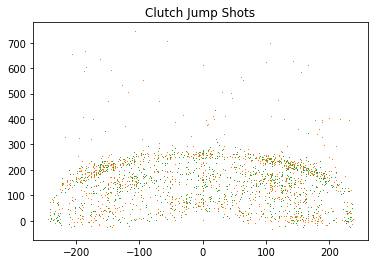

In [34]:
X = made_clutch_jump_shot
Y = missed_clutch_jump_shot

plt.figure()
for index, row in X.head(1000).iterrows():
    plt.plot(X.get_value(index, 'loc_x'), X.get_value(index, 'loc_y'), ',', color='C2')
for index, row in Y.head(1000).iterrows():
    plt.plot(Y.get_value(index, 'loc_x'), Y.get_value(index, 'loc_y'), ',', color='C1')
plt.title("Clutch Jump Shots")
plt.show()


Text(0.5,0,'time [seconds from start of game]')

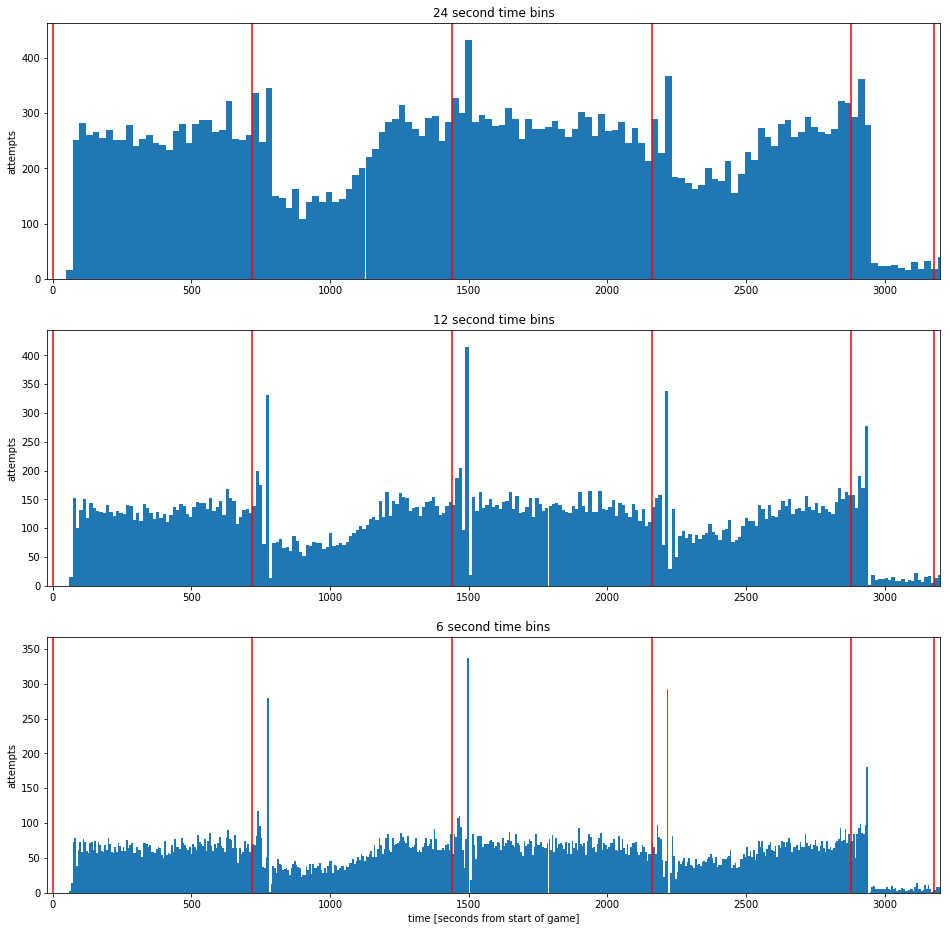

In [49]:
plt.rcParams['figure.figsize'] = (16, 16)

binsSizes = [24,12,6]
quarter = 12 * 60
plt.figure();
# for k, bins in enumerate(bins_sizes):
#     time_bin = np.arange(0,60*(4*12+3*5),bins)+0.01
#     attempts, b = np.histogram(data['seconds_from_game_start'], bins=time_bin)     
    
#     graph_height = max(attempts) + 30
#     barWidth = 0.999*(time_bin[1]-time_bin[0])
#     plt.subplot(len(bins_sizes),1,k+1); 
#     plt.bar(time_bin[:-1],attempts, align='edge', width=barWidth); plt.title(str(bins) + ' second time bins')
#     plt.vlines(x=[0,quarter,2*quarter,3*quarter,4*quarter,4*quarter+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=graph_height, colors='r')
#     plt.xlim((-20,3200)); plt.ylim((0,graph_height)); plt.ylabel('Attempts')
# plt.xlabel('time')
# for k, bins in enumerate(bins_sizes):
#     timeBins = np.arange(0,60*(4*12+3*5),bins)+0.01
#     attempts, b = np.histogram(data['seconds_from_game_start'], bins=timeBins)     
    
#     maxHeight = max(attemptsAsFunctionOfTime) + 30
#     barWidth = 0.999*(timeBins[1]-timeBins[0])
#     plt.subplot(len(bins_sizes),1,k+1); 
#     plt.bar(timeBins[:-1],attempts, align='edge', width=barWidth); plt.title(str(bins) + ' second time bins')
#     plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
#     plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
# plt.xlabel('time [seconds from start of game]')
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60*(4*12+3*5),binSizeInSeconds)+0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['seconds_from_game_start'], bins=timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999*(timeBins[1]-timeBins[0])
    plt.subplot(len(binsSizes),1,k+1); 
    plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth); plt.title(str(binSizeInSeconds) + ' second time bins')
    plt.vlines(x=[0,12*60,2*12*60,3*12*60,4*12*60,4*12*60+5*60,4*12*60+2*5*60,4*12*60+3*5*60], ymin=0,ymax=maxHeight, colors='r')
    plt.xlim((-20,3200)); plt.ylim((0,maxHeight)); plt.ylabel('attempts')
plt.xlabel('time [seconds from start of game]')